In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
from utils import *
from IPython.display import display, Markdown, HTML 
import markdown2

def get_ordered_scores(df):
    def order_scores(df_performance, df_demo):
        for (i, drow), (i, prow) in zip(df_demo[['participant',0,1,2,3]].iterrows(), df_performance.iterrows()):
            #print(drow, prow)
            assert drow['participant'] == prow['participant']
            drow = drow.to_list()        
            yield [drow[0]] + [prow[i] for i in drow[1:]] # reorder
            
    df = df[['participant', 'experiment', 'total']]
    df = df.pivot(index='participant', columns='experiment', values='total')
    exp = df.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    df = df.reset_index()
    df_demo = get_demographics_data()
    # scores for each participant ordered by the time they performed the experiment
    df_raw = pd.DataFrame(order_scores(df, df_demo), columns=['participant',0,1,2,3])
    # correct for difference in difficulty. This is quite crude as the distributions are not Gaussian...?
    df_c = df.copy()
    df_c[exp] = df_c[exp] - df_c[exp].mean() 
    df_cor = pd.DataFrame(order_scores(df_c, df_demo), columns=['participant',0,1,2,3])
    ncols = df_raw.select_dtypes(include='number').columns
    mean_score = df_raw[ncols].mean().to_numpy()
    mean_score_corrected = df_cor[ncols].mean().to_numpy()
    return SimpleNamespace(
            score=df_raw, 
            score_corrected=df_cor,
            mean=pd.DataFrame(data={'mean score':mean_score, 'mean score corrected':mean_score_corrected}),
    )

pd.set_option("display.max_rows", 100)


In [2]:
fp = Statistics.compute_failure_proportion_statistics()
fl = Statistics.compute_failure_length_statistics()
fc = Statistics.compute_failure_count_statistics()
scores = dict(FP=fp, FL=fl, FC=fc)

========================= FP ==============================


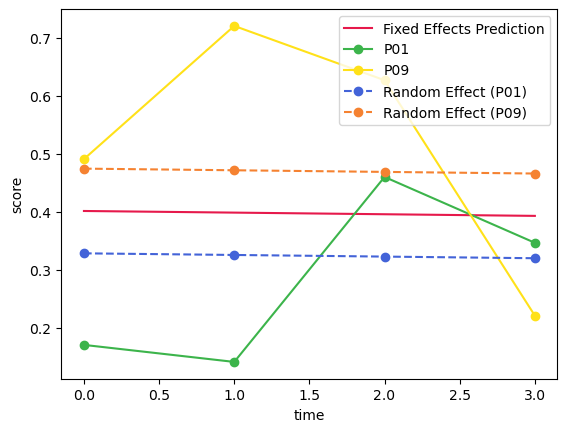

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# it looks like rather than correcting using the mean value, we can do nested grouping - see bottom of:
# TODO https://www.statsmodels.org/dev/generated/statsmodels.formula.api.mixedlm.html


# do simple linear regression on corrected scores
for name, score in scores.items():
    print(f"========================= {name} ==============================")
    df = get_ordered_scores(score).score
    
    df = df.melt(id_vars='participant', var_name='time', value_name='score')
    df['time'] = df['time'].astype(np.float32)
    df['score'] = df['score'].astype(np.float32)
    df = df[::8]
    
    # TODO this is apparently a hierarchical X + Group + (X | Participant)
    
    md = smf.mixedlm("score ~ time", df, groups=df["participant"])
    mdf = md.fit()
   
    df['FixedEffectPrediction'] = mdf.predict(df) # fixed effects predictions
    # Plot the fixed effects predictions
    fig, ax = plt.subplots()
    plt.plot(df['time'], df['FixedEffectPrediction'], label='Fixed Effects Prediction')

    for participant, group_data in df.groupby('participant'):
        group_data = group_data.sort_values('time')  # Sort data points by X for proper line plotting
        ax.plot(group_data['time'], group_data['score'], marker='o', label=participant)
    
    # Plot random effects for each participant
    for participant in mdf.random_effects:
        participant_data = df[df['participant'] == participant]
        random_effect = mdf.random_effects[participant]
        plt.plot(participant_data['time'], participant_data['FixedEffectPrediction'] + random_effect.item(),
                 marker='o', linestyle='--', label=f'Random Effect ({participant})')

    # Set plot labels and legend
    plt.xlabel('time')
    plt.ylabel('score')
    plt.legend()

    # Display the plot
    plt.show()

    break

    
    # TODO heirarchical
    
    #x, y = df[['X']].astype(float), df['Y']
    #x = sm.add_constant(x)
    #model = sm.OLS(y, x).fit()
    #
    #print(model.summary(), "\n")

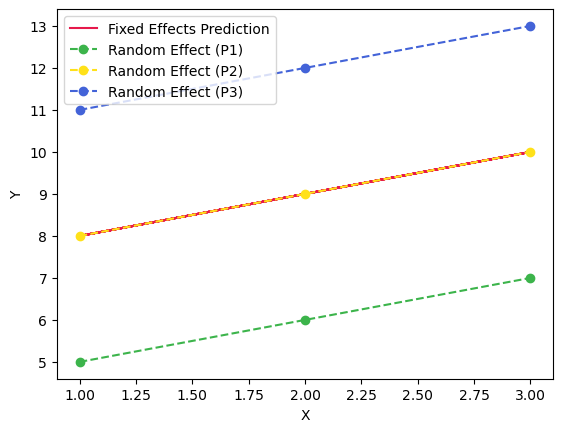

In [34]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# Create a sample DataFrame
data = {'Participant': ['P1', 'P1', 'P1', 'P2', 'P2', 'P2', 'P3', 'P3', 'P3'],
        'X': [1, 2, 3, 1, 2, 3, 1, 2, 3],
        'Y': [5, 6, 7, 8, 9, 10, 11, 12, 13]}
df = pd.DataFrame(data)

# Fit a mixed linear model
model = smf.mixedlm("Y ~ X", df, groups=df['Participant'])
result = model.fit()

# Extract fixed effects predictions
df['FixedEffectPrediction'] = result.predict(df)

# Extract random effects
random_effects = result.random_effects
#print(random_effects)
#print(df)

# Plot the fixed effects predictions
plt.plot(df['X'], df['FixedEffectPrediction'], label='Fixed Effects Prediction')

# Plot random effects for each participant
for participant in random_effects:
    participant_data = df[df['Participant'] == participant]
    random_effect = random_effects[participant]
    plt.plot(participant_data['X'], participant_data['FixedEffectPrediction'] + random_effect.item(),
             marker='o', linestyle='--', label=f'Random Effect ({participant})')

# Set plot labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Display the plot
plt.show()


In [11]:
# do simple linear regression on corrected scores
# NOTE: this leads to bad p-values... FP and FL have a negative slope indicating improvement (but pvalues are too high)

import statsmodels.api as sm
for name, score in scores.items():
    #score = get_ordered_scores(score).score
    score = get_ordered_scores(score).score_corrected
    
    ncols = score.select_dtypes(include='number').columns
    df = score[ncols].melt(var_name='X', value_name='Y')
    x, y = df[['X']].astype(float), df['Y']
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    print(f"=================================== {name} =======================================")
    print(model.summary(), "\n")
    #plt.figure(figsize=(12,3))
    #plt.scatter(x.to_numpy()[:,1], y)
    break

=================================== FP =======================================
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.133
Date:                Tue, 11 Jul 2023   Prob (F-statistic):              0.149
Time:                        17:48:25   Log-Likelihood:                 10.609
No. Observations:                  64   AIC:                            -17.22
Df Residuals:                      62   BIC:                            -12.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

False

In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
data = sm.datasets.get_rdataset('dietox', 'geepack').data

print(data)

md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula="~Time")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

      Pig     Evit     Cu  Litter  Start     Weight        Feed  Time
0    4601  Evit000  Cu000       1   26.5   26.50000         NaN     1
1    4601  Evit000  Cu000       1   26.5   27.59999    5.200005     2
2    4601  Evit000  Cu000       1   26.5   36.50000   17.600000     3
3    4601  Evit000  Cu000       1   26.5   40.29999   28.500000     4
4    4601  Evit000  Cu000       1   26.5   49.09998   45.200001     5
..    ...      ...    ...     ...    ...        ...         ...   ...
856  8442  Evit000  Cu175      24   25.7   73.19995   83.800003     8
857  8442  Evit000  Cu175      24   25.7   81.69995   99.800003     9
858  8442  Evit000  Cu175      24   25.7   90.29999  115.200001    10
859  8442  Evit000  Cu175      24   25.7   96.00000  133.200001    11
860  8442  Evit000  Cu175      24   25.7  103.50000  151.400002    12

[861 rows x 8 columns]
           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861     